# Flights data exploration
# Exploration
## by Kacper Fiszer
I have looked at and wrangled part of United States flight data.  
The whole data available consisted of years 1987-2008.  
For this particular project I've picked years 2005-2007 (2008 had data only for the first months).  
  
In the exploration and analysis to follow I will concentrate on delays and even more on flight cancellation/diverting aspects.  
As a result of wrangling I will use:
- a separated dataset for cancelled or diverted flights for some exploration,
- a sample of cleaned, full flight dataset.

Column descriptions are available here:
http://stat-computing.org/dataexpo/2009/the-data.html

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
# load cancelled and diverted flights data
df = pd.read_csv('./data/flights_cancelled.csv')

# load full cleaned flight data for the purpose of calculating proportions and extracting a sample
df_full = pd.read_csv('./data/flights_clean.csv')

In [3]:
# extract a sample
df_sample = df_full.sample(10000).copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463767 entries, 0 to 463766
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Year               463767 non-null  int64  
 1   Month              463767 non-null  int64  
 2   DayofMonth         463767 non-null  int64  
 3   DayOfWeek          463767 non-null  int64  
 4   DepTime            47358 non-null   object 
 5   CRSDepTime         463767 non-null  object 
 6   CRSArrTime         463767 non-null  object 
 7   UniqueCarrier      463767 non-null  object 
 8   CRSElapsedTime     462769 non-null  float64
 9   DepDelay           47358 non-null   float64
 10  Origin             463767 non-null  object 
 11  Dest               463767 non-null  object 
 12  Distance           463767 non-null  int64  
 13  Cancelled          463767 non-null  int64  
 14  CancellationCode   416409 non-null  object 
 15  Diverted           463767 non-null  int64  
 16  Ca

In [5]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,CRSElapsedTime,DepDelay,...,Dest,Distance,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2005,1,5,3,NaN,19:00:00,22:32:00,UA,152.0,NaN,...,BOS,867,1,B,0,0,0,0,0,0
1,2005,1,16,7,19:11:00,19:00:00,22:23:00,UA,143.0,11.0,...,BOS,867,0,NaN,1,0,0,0,0,0
2,2005,1,23,7,NaN,19:00:00,22:23:00,UA,143.0,NaN,...,BOS,867,1,B,0,0,0,0,0,0
3,2005,1,24,1,NaN,19:00:00,22:23:00,UA,143.0,NaN,...,BOS,867,1,A,0,0,0,0,0,0
4,2005,1,26,3,NaN,19:00:00,22:23:00,UA,143.0,NaN,...,BOS,867,1,A,0,0,0,0,0,0


In [6]:
df.describe()

,Year,Month,DayofMonth,DayOfWeek,CRSElapsedTime,DepDelay,Distance,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,463767.000000,463767.000000,463767.000000,463767.000000,462769.000000,47358.000000,463767.000000,463767.000000,463767.000000,463767.0,463767.0,463767.0,463767.0,463767.0
mean,2006.065069,6.275988,16.099138,3.868867,114.815966,25.108176,602.812649,0.897884,0.102116,0.0,0.0,0.0,0.0,0.0
std,0.835465,3.649834,8.653336,1.946398,60.280453,59.178032,480.665773,0.302801,0.302801,0.0,0.0,0.0,0.0,0.0
min,2005.000000,1.000000,1.000000,1.000000,0.000000,-1123.000000,11.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,2005.000000,3.000000,9.000000,2.000000,73.000000,-2.000000,264.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,2006.000000,6.000000,16.000000,4.000000,100.000000,2.000000,478.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,2007.000000,9.000000,24.000000,5.000000,140.000000,28.000000,770.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,2007.000000,12.000000,31.000000,7.000000,1430.000000,1272.000000,4962.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0


## Quick cleanup
There are few leftovers from the original wrangling that can be taken care of in the cancelled/diverted flights subset:
- Delays by category can be removed, as these were not recorded/kept for cancelled nor diverted flights.
- Cancelled & Diverted columns can be merged into one categorical column called 'Anomaly'.
- Data types can be fixed as per original wrangling.

In [7]:
# Add and fill new Anomaly column (categorical)
df['Anomaly'] = np.nan
df.loc[df['Cancelled'] == 1, 'Anomaly'] = 'Cancelled'
df.loc[df['Diverted'] == 1, 'Anomaly'] = 'Diverted'
df['Anomaly'] = df['Anomaly'].astype('category')

# Drop unused columns
df.drop(columns=['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Cancelled', 'Diverted'], inplace=True)

In [8]:
# Assign ordered categorical data type to Carriers
carr_counts = df['UniqueCarrier'].value_counts()
carr_cat = pd.api.types.CategoricalDtype(carr_counts.index, ordered=True)
df['UniqueCarrier'] = df['UniqueCarrier'].astype(carr_cat)

In [9]:
# Fix CancellationCode to be ordered categorical
cancel_counts = df['CancellationCode'].value_counts()
cancel_cat = pd.api.types.CategoricalDtype(cancel_counts.index, ordered=True)
df['CancellationCode'] = df['CancellationCode'].astype(cancel_cat)

In [10]:
# Fix float64 to Int64 (allowing for NaN)
df = df.astype({'CRSElapsedTime':'Int64', 'DepDelay':'Int64'})

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 463767 entries, 0 to 463766
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Year              463767 non-null  int64   
 1   Month             463767 non-null  int64   
 2   DayofMonth        463767 non-null  int64   
 3   DayOfWeek         463767 non-null  int64   
 4   DepTime           47358 non-null   object  
 5   CRSDepTime        463767 non-null  object  
 6   CRSArrTime        463767 non-null  object  
 7   UniqueCarrier     463767 non-null  category
 8   CRSElapsedTime    462769 non-null  Int64   
 9   DepDelay          47358 non-null   Int64   
 10  Origin            463767 non-null  object  
 11  Dest              463767 non-null  object  
 12  Distance          463767 non-null  int64   
 13  CancellationCode  416409 non-null  category
 14  Anomaly           463767 non-null  category
dtypes: Int64(2), category(3), int64(5), object(5)
memor

In [12]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,CRSArrTime,UniqueCarrier,CRSElapsedTime,DepDelay,Origin,Dest,Distance,CancellationCode,Anomaly
0,2005,1,5,3,NaN,19:00:00,22:32:00,UA,152,<NA>,ORD,BOS,867,B,Cancelled
1,2005,1,16,7,19:11:00,19:00:00,22:23:00,UA,143,11,ORD,BOS,867,NaN,Diverted
2,2005,1,23,7,NaN,19:00:00,22:23:00,UA,143,<NA>,ORD,BOS,867,B,Cancelled
3,2005,1,24,1,NaN,19:00:00,22:23:00,UA,143,<NA>,ORD,BOS,867,A,Cancelled
4,2005,1,26,3,NaN,19:00:00,22:23:00,UA,143,<NA>,ORD,BOS,867,A,Cancelled


In [13]:
df_sample.describe()

,Year,Month,DayofMonth,DayOfWeek,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,9791.000000,10000.000000,9791.000000,9791.000000,9816.000000,10000.000000,10000.000000,10000.000000,10000.0000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2006.006800,6.501000,15.697200,3.9686,2161.886000,125.607497,126.670500,102.934430,8.520580,9.919825,721.852900,6.499400,15.753500,0.0184,0.00250,3.333200,0.605400,3.603900,0.029300,4.385700
std,0.818059,3.421048,8.777803,1.9964,1946.630362,71.077649,70.337616,68.927003,36.222321,32.485291,568.846848,4.826959,11.231507,0.1344,0.04994,18.003405,8.504265,15.501078,0.955266,19.432784
min,2005.000000,1.000000,1.000000,1.0000,1.000000,18.000000,22.000000,3.000000,-55.000000,-28.000000,31.000000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,4.000000,8.000000,2.0000,602.000000,75.000000,76.000000,54.000000,-9.000000,-4.000000,316.000000,4.000000,10.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.000000,7.000000,16.000000,4.0000,1505.000000,106.000000,108.000000,83.000000,-1.000000,0.000000,555.000000,5.000000,13.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2007.000000,9.000000,23.000000,6.0000,3339.000000,156.000000,156.000000,131.000000,12.000000,9.000000,950.250000,8.000000,18.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2007.000000,12.000000,31.000000,7.0000,9576.000000,600.000000,596.000000,577.000000,856.000000,745.000000,4502.000000,77.000000,217.000000,1.0000,1.00000,605.000000,491.000000,324.000000,56.000000,379.000000


In [14]:
# Create additional categorical column for distance to ease multivariate exploration
# bins roughly equal quartiles
bins = [0, 300, 600, 1000, 2000, 5000]
names = ['0-300', '300-600', '600-1000', '1000-2000', '2000-5000']

df_sample['DistanceCat'] = pd.cut(df_sample['Distance'], bins=bins, labels=names)

### Structure of the dataset
The cancelled/diverted flights subset contains nearly half a million records in 21 columns.  
Flight date values are split into separate integer columns for day, month and year.
Separate column is present for day of week.
Departure and arrival times are stored as date.time object - probably will not be used in this analysis.
Carriers, Cancellation Codes and Anomaly (cancelled or diverted) are stored in categorical columns.

### Relations potentially worth exploring
#### All flights (sample)
- Relation between distance and arrival delay (bivariate)
- Relation between departure delay and arrival delay (bivariate)
- Relation between scheduled flight time and actual elapsed flight time (bivariate)  
  
  
- Relation between departure delay and arrival delay + categorical distance (univariate)
- Relation between scheduled flight time and actual elapsed flight time + categorical distance (univariate) 

#### Cancelled/diverted flights subset:
- Count of cancelled or diverted flights by year (univariate)  
To see if there are significant changes year-to-year
- Count of cancelled or diverted flights by month (univariate)  
Potential correlation might indicate seasonal cause-effect
- Count of cancelled or diverted flights by day of week  
Are there more cancelled or diverted flights during specific week days?
- Count of cancelled or diverted flights by distance (univariate)  
Could flight distance influence cancellations or diverting?
- Proportion of cancellation codes (univariate)  
To see what are the most frequent reasons of flight cancellation.
  
  
- Count of cancelled or diverted flights by year and month or month and day of week (bivariate)  
To better understand time-related trends.
- Cancellation codes in relation to flight distance (bivariate)
Could these be related?

## Univariate Exploration
First, I will create tiny, supporting dataframes with proportion calculations.

In [15]:
# Proportion of cancelled or diverted flights to all flights in a year
prop_byyear = df['Year'].value_counts().sort_index() / df_full['Year'].value_counts().sort_index()
prop_byyear = prop_byyear.reset_index()
prop_byyear.rename(columns={'index':'Year', 'Year':'Proportion'}, inplace=True)
prop_byyear

,Year,Proportion
0,2005,0.020710
1,2006,0.019345
2,2007,0.023872


In [16]:
# Proportion of cancelled or diverted flights to all flights in a month
prop_bymonth = df['Month'].value_counts().sort_index() / df_full['Month'].value_counts().sort_index()
prop_bymonth = prop_bymonth.reset_index()
prop_bymonth.rename(columns={'index':'Month', 'Month':'Proportion'}, inplace=True)
prop_bymonth

,Month,Proportion
0,1,0.030622
1,2,0.030279
2,3,0.020333
3,4,0.015765
4,5,0.012620
5,6,0.023249
6,7,0.023267
7,8,0.021452
8,9,0.017625
9,10,0.017529


In [17]:
# Proportion of cancelled or diverted flights to all flights by day of week
prop_byday = df['DayOfWeek'].value_counts().sort_index() / df_full['DayOfWeek'].value_counts().sort_index()
prop_byday = prop_byday.reset_index()
prop_byday.rename(columns={'index':'DayOfWeek', 'DayOfWeek':'Proportion'}, inplace=True)
prop_byday

,DayOfWeek,Proportion
0,1,0.020934
1,2,0.021764
2,3,0.023175
3,4,0.023196
4,5,0.021926
5,6,0.018048
6,7,0.019870


In [18]:
base_color = sb.color_palette()[0]

How big a part are cancelled or diverted flights?

In [19]:
df.shape[0] / df_full.shape[0]

0.021346312643089848

### Count and proportion of cancelled or diverted flights by year

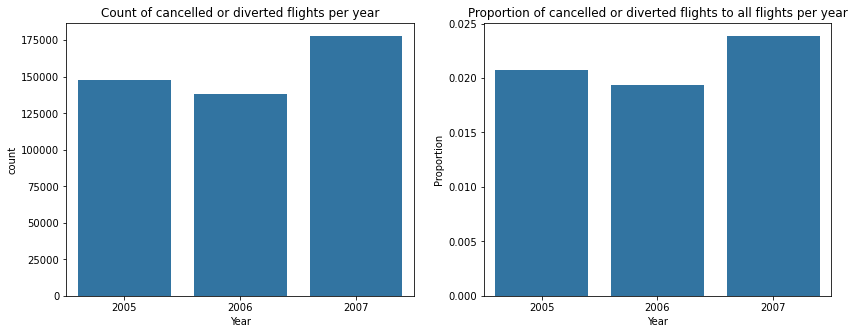

In [20]:
plt.figure(figsize=(12,5))

plt.subplot(121)
sb.countplot(data=df, x='Year', color=base_color)
plt.title('Count of cancelled or diverted flights per year');

plt.subplot(122)
sb.barplot(data=prop_byyear, x='Year', y='Proportion', color=base_color)
plt.title('Proportion of cancelled or diverted flights to all flights per year');
plt.tight_layout(pad=2)

These two plots look much alike.  
Even though there were more flights in 2007 compared to previous years, the proportion of cancelled or diverted flights increased similarly to the raw number.

### Count and proportion of cancelled or diverted flights by month

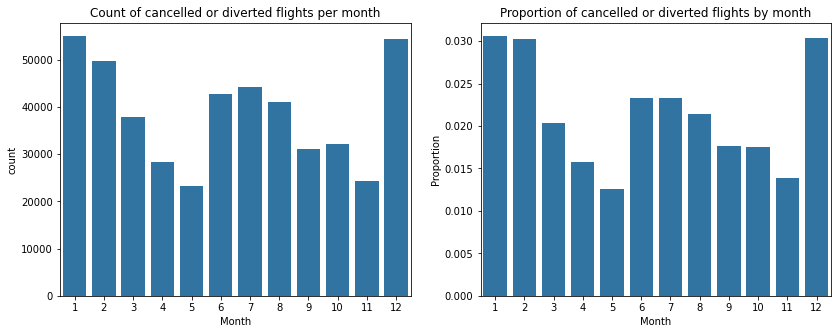

In [21]:
plt.figure(figsize=(12,5))

plt.subplot(121)
sb.countplot(data=df, x='Month', color=base_color)
plt.title('Count of cancelled or diverted flights per month');

plt.subplot(122)
sb.barplot(data=prop_bymonth, x='Month', y='Proportion', color=base_color)
plt.title('Proportion of cancelled or diverted flights by month');
plt.tight_layout(pad=2)

Again, there is no significant change in distribution between raw numbers and proportion.  
Admittedly, this is surprising for me. At first I thought that more cancelled or diverted flights could be associated with winter conditions (this actually appears likely) and possibly more flights taking place in the summer season.  
That's why I wanted to confront counts with proportions in the first place.  

### Distribution of all flights by month
This point is here just to confirm the above.  
Since proportions plot looks much like count plot, the actual number of flights happening each month should be mostly the same.

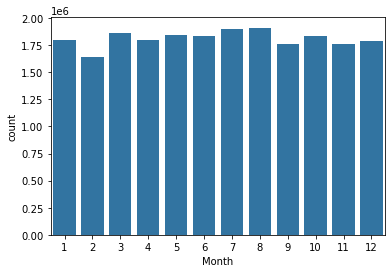

In [22]:
sb.countplot(data=df_full, x='Month', color=base_color);

### Count and proportion of cancelled or diverted flights by day of week

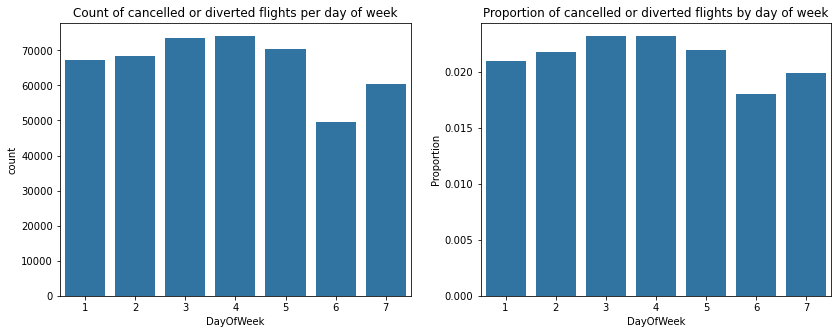

In [23]:
plt.figure(figsize=(12,5))

plt.subplot(121)
sb.countplot(data=df, x='DayOfWeek', color=base_color)
plt.title('Count of cancelled or diverted flights per day of week');

plt.subplot(122)
sb.barplot(data=prop_byday, x='DayOfWeek', y='Proportion', color=base_color)
plt.title('Proportion of cancelled or diverted flights by day of week');
plt.tight_layout(pad=2)

And for the third time proportion behaves mostly similarly to distribution of counts.  
The proportion of cancelled or diverted flights on weekends is a bit higher than raw counts would suggest.  
Still weekends and Saturdays in particular were the 'safest' days to avoid flight being cancelled or diverted.

### Count of cancelled or diverted flights by distance

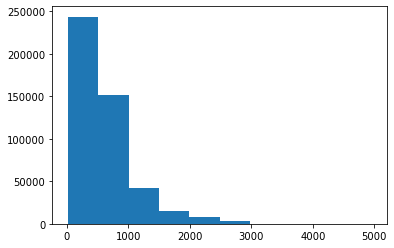

In [24]:
plt.hist(data=df, x='Distance');

Logarithmic scale for x and adjusting bins should get more out of this plot.

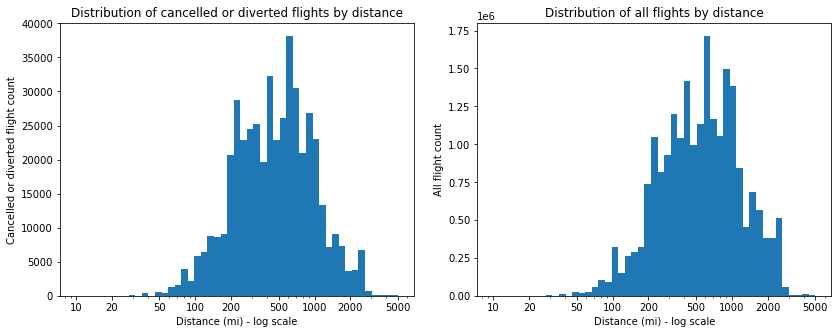

In [25]:
bins = np.logspace(np.log10(10), np.log10(5000), 50)
x_ticks = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(data=df, x='Distance', bins=bins)
plt.xscale('log')
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Distance (mi) - log scale')
plt.ylabel('Cancelled or diverted flight count')
plt.title('Distribution of cancelled or diverted flights by distance');

plt.subplot(122)
plt.hist(data=df_full, x='Distance', bins=bins)
plt.xscale('log')
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Distance (mi) - log scale')
plt.ylabel('All flight count')
plt.title('Distribution of all flights by distance')
plt.tight_layout(pad=2);

On a logarithmic scale, the distribution of flight distances appears more normal, with a few peaks.  
Possibly popular big city destinations generating lots of traffic between themselves?  
In any case, the similarity between two distributions suggests that whether or not flight ends up cancelled or diverted doesn't correlate with flight distance.

### Proportion of cancellation reasons

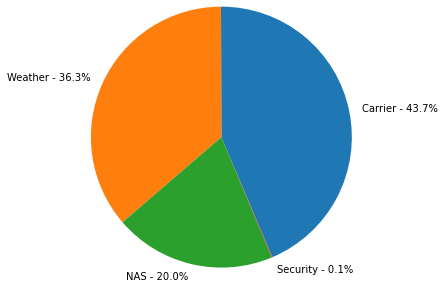

In [26]:
cancel_counts = df['CancellationCode'].value_counts().sort_index().reset_index().rename(columns={'index':'Code', 'CancellationCode':'Count'})
cancel_counts['Prop'] = cancel_counts['Count'] / cancel_counts['Count'].sum()
cancel_counts['Descr'] = ['Carrier', 'Weather', 'NAS', 'Security']
cancel_counts['Label'] = cancel_counts['Descr'] + ' - ' + cancel_counts['Prop'].apply(lambda x: str(round(x, 3)*100)) + '%'

plt.pie(data=cancel_counts, x='Count', labels=cancel_counts['Label'], startangle=-67, radius=1.5);

## Bivariate Exploration

### Cancellation reasons in relation to distance

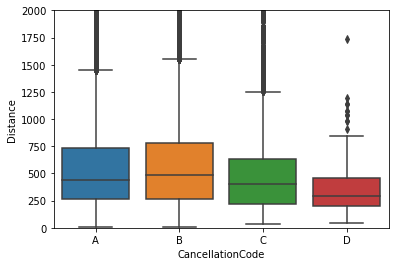

In [27]:
sb.boxplot(data=df, x='CancellationCode', y='Distance', palette='tab10')
plt.ylim(0, 2000);

### Cancelled or diverted flights by month and day of week

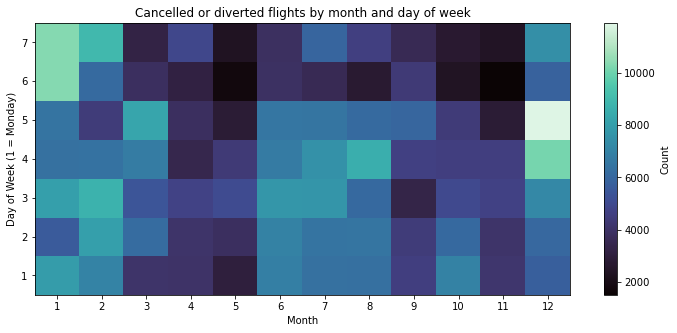

In [28]:
plt.figure(figsize=(12,5))
xbin_edges = np.arange(0.5, 13, 1)
ybin_edges = np.arange(0.5, 8, 1)
x_ticks = np.arange(1, 13)

plt.hist2d(data=df, x='Month', y='DayOfWeek', bins=[xbin_edges, ybin_edges], cmap='mako')
plt.xticks(x_ticks, x_ticks)
plt.colorbar(label='Count')
plt.xlabel('Month')
plt.ylabel('Day of Week (1 = Monday)')
plt.title('Cancelled or diverted flights by month and day of week');

There is a higher chance of flight getting cancelled or diverted on December Fridays.
Christmas peak?  
Conversely, the least cancelled/diverted flights occured on May and November Saturdays.

### Relation between distance and arrival delay

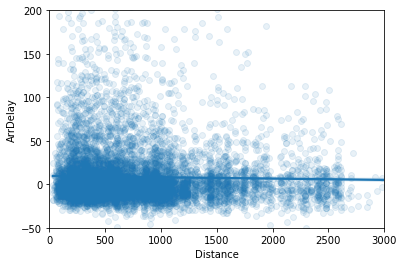

In [36]:
sb.regplot(data=df_sample, x='Distance', y='ArrDelay', scatter_kws={'alpha':0.1})
plt.xlim(0, 3000)
plt.ylim(-50, 200);

Appears as though distance doesn't influence arrival delays.

### Relation between departure delay and arrival delay
Warning: contains product placement

(-50.0, 200.0)

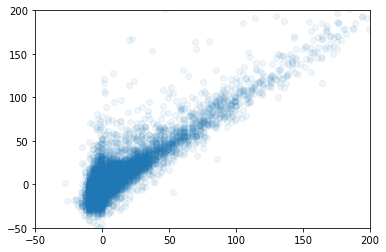

In [30]:
plt.scatter(data=df_sample, x='DepDelay', y='ArrDelay', alpha=0.07)
plt.xlim(-50, 200)
plt.ylim(-50, 200)

The relation here is very linear for longer delays, but in the region of 0 +- 30 minutes everything can happen.  
That is, flights ahead of schedule on departure can arrive late or vice versa.

### Relation between scheduled flight time and actual elapsed time

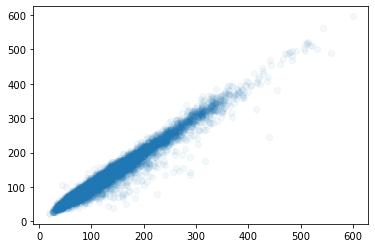

In [38]:
plt.scatter(data=df_sample, x='ActualElapsedTime', y='CRSElapsedTime', alpha=0.05);

As linear as can get.

## Multivariate Exploration
### Relation between departure delay and arrival delay + categorical distance

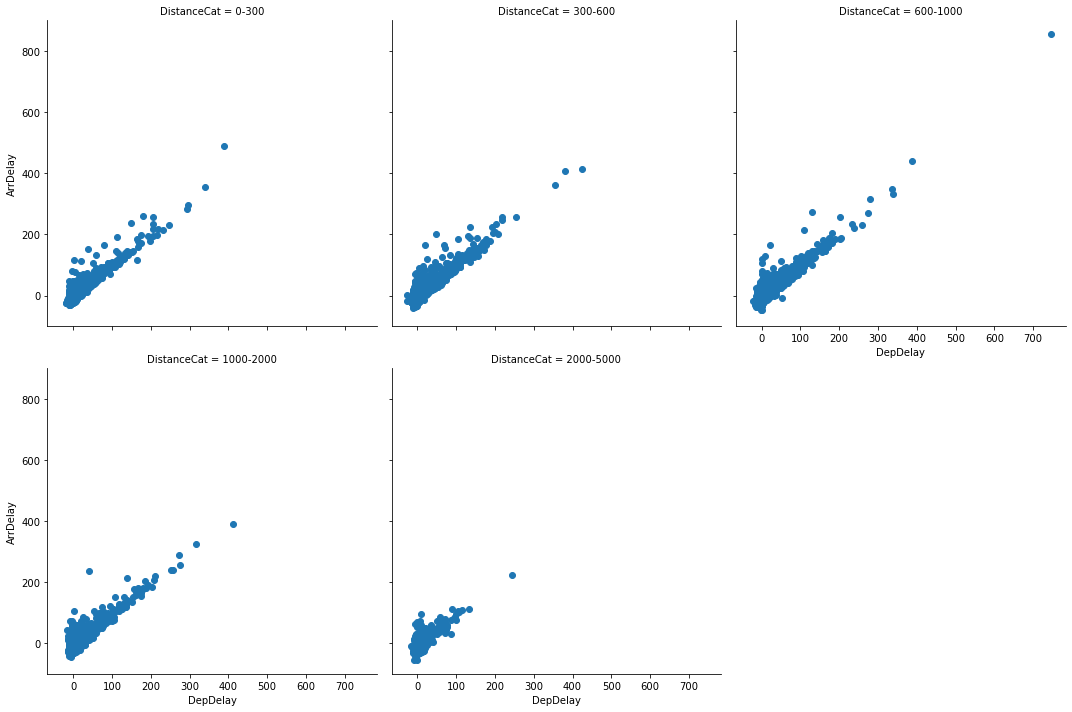

In [32]:
g = sb.FacetGrid(data=df_sample, col='DistanceCat', col_wrap=3, height=5)
g.map(plt.scatter, 'DepDelay', 'ArrDelay');

There are fewer points for long distances, simply because there are fewer long flights.  
Other than that, distance doesn't seem to have impact on departure delay to arrival delay relationship.

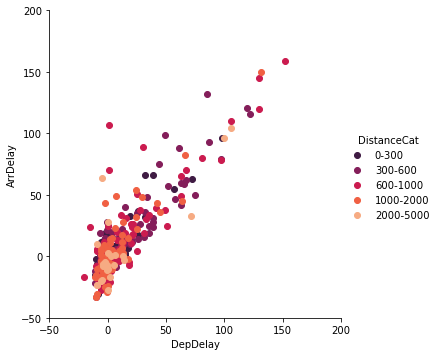

In [33]:
g = sb.FacetGrid(data=df_sample.sample(500), hue='DistanceCat', height=5, palette='rocket')
g.map(plt.scatter, 'DepDelay', 'ArrDelay')
g.add_legend()

plt.xlim(-50, 200)
plt.ylim(-50, 200);

As in the grid above - distance doesn't have impact on departure delay to arrival delay relationship.

### Relation between scheduled flight time and actual elapsed flight time + categorical distance

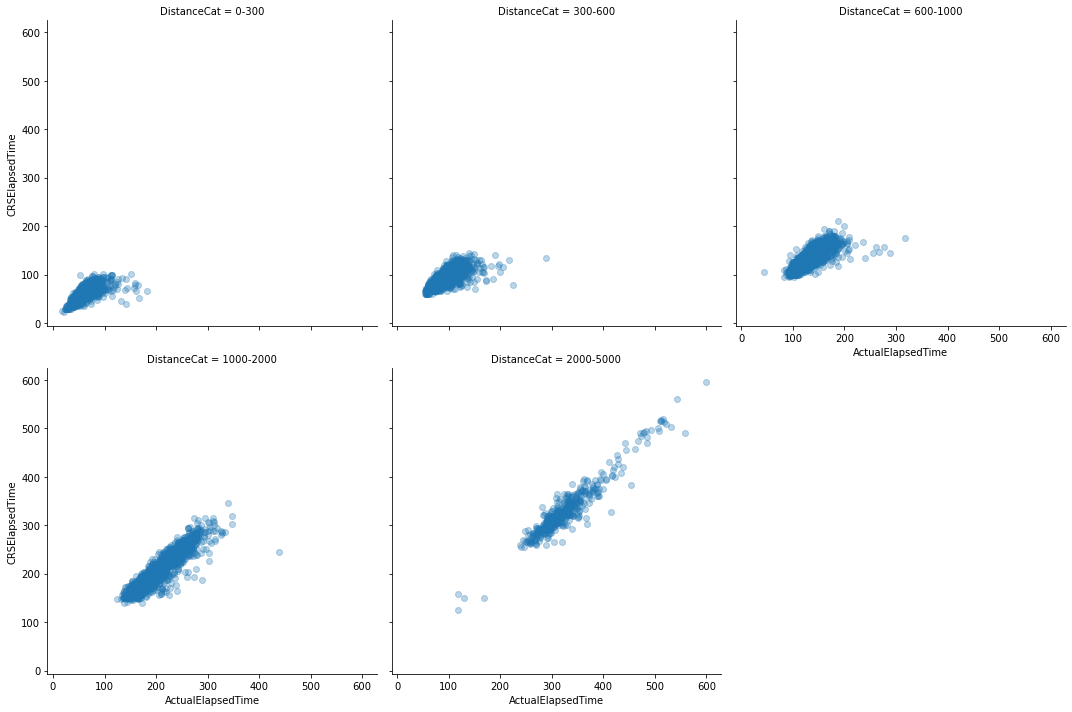

In [34]:
g = sb.FacetGrid(data=df_sample, col='DistanceCat', col_wrap=3, height=5)
g.map(plt.scatter, 'ActualElapsedTime', 'CRSElapsedTime', alpha=0.3);

As noted previously, the relationship between scheduled and actual elapsed time is linear.  
Howver when we break it down by distance categories, it appears that for shorter distances there is more variance between the points.

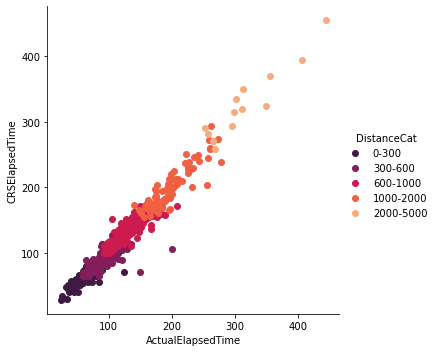

In [35]:
g = sb.FacetGrid(data=df_sample.sample(500), hue='DistanceCat', height=5, palette='rocket')
g.map(plt.scatter, 'ActualElapsedTime', 'CRSElapsedTime')
g.add_legend();

Pieces brought together bring you a tequila sunrise kind of visual experience.  
Not much to see here except that, surprise, surprise: longer distances take more time to fly.